In [4]:
pd.set_option('display.max_rows', None)

In [3]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

Step_1: Extracting the data from given HTML files using OS and BeautifulSoup

In [ ]:
import os  # Import the os module for interacting with the operating system
from bs4 import BeautifulSoup  # Import BeautifulSoup for parsing HTML
import pandas as pd  

def extract_tables_from_html(folder_path):
    tables = []
    for root, _, files in os.walk(folder_path):# Iterate over files and directories in the given folder
        for file in files:
            if file.endswith('.html'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    soup = BeautifulSoup(f, 'lxml')# Parse the HTML content using BeautifulSoup
                    for table in soup.find_all('table'):# Find all HTML tables in the content
                        df = pd.read_html(str(table))[0]
                        tables.append((df, root.split(os.sep)[-1]))  # (DataFrame, Category)
    return tables

folder_path = r'C:\Users\siva_\.vscode\task\data'
tables = extract_tables_from_html(folder_path)

Step_2: Convert the extracted data into Dataframe for manipulation and pre-process

In [134]:

import re

def preprocess_tables(tables):
    data = []
    labels = []
    for df, label in tables:
        # Flatten table into a single string
        table_str = ' '.join(df.astype(str).apply(' '.join, axis=1))
        # table_str = re.sub('[a-zA-Z\s]', ' ', table_str).lower()
        data.append(table_str)
        labels.append(label)
    return data, labels

data, labels = preprocess_tables(tables)

In [135]:
df = pd.DataFrame({
    'table_data' : data,
    'label' : labels
})

<Axes: xlabel='label'>

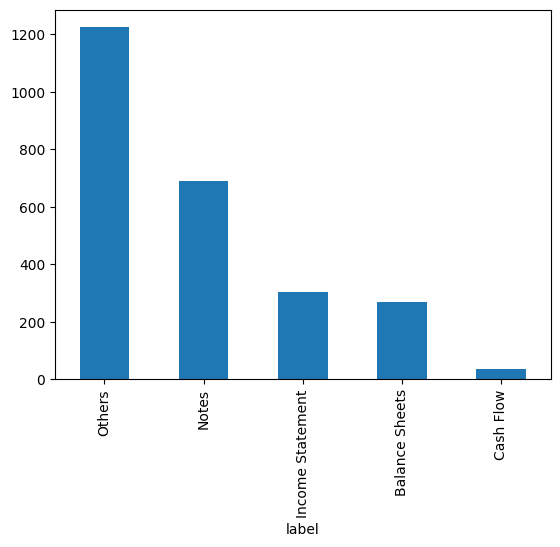

In [236]:
#checking the data imbalance on classes:

df['label'].value_counts()
df['label'].value_counts().plot(kind='bar') # it clearly shows that the data is imbalanced and Others class is major class while comparing to others.

Step_3: Text pre processing:

In [ ]:
df1 = df.copy()#make copy of dataframe

In [ ]:
#remove nan and multiple spaces from table data and converting it as lowercase:
#Using regular expressions to remove Nan, multiple spaces, and non-alphabetic characters

for i in range(len(df1['table_data'])):
    text = df1['table_data'][i]
    # Remove 'nan'
    text = re.sub(r'\bnan\b', '', text)
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z\s]', ' ', text).lower()
    # Replace multiple spaces with a single space, keeping necessary spaces
    text = re.sub(r'\s+', ' ', text.strip())
    df1['table_data'][i] = text

Text_Pre-processing using NLTK(tokenization & Lemmatization)

In [ ]:
pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')# for lemmatization process

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# tokens = word_tokenize(df1['table_data'][0])
tokens = [word_tokenize(df1['table_data'][i])  for i in range(len(df1['table_data']))]

lemmatizer = WordNetLemmatizer()
lemmatized_tokens = []
for text in df1['table_data']:
    tokens = word_tokenize(text)  # Tokenize the text
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token
    lemmatized_tokens.append(lemmatized_text)  # Append the lemmatized tokens to the list

# Join the lemmatized tokens back into strings
lemmatized_texts = [' '.join(tokens) for tokens in lemmatized_tokens]
df1['lematized_texts'] = lemmatized_texts

Step_4: Converting the corpus into vectors using TF-IDF vectorizer and train a model:

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df1['lematized_texts'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df1['label'], test_size=0.2, random_state=42)

# Training the model (Logistic Regression example)
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(" Logistic Regression Accuracy:", accuracy)

 Logistic Regression Accuracy: 0.900990099009901


In [210]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("RandomForestClassifier Accuracy:", accuracy)

RandomForestClassifier Accuracy: 0.9287128712871288


In [211]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVC Accuracy:", accuracy)

SVC Accuracy: 0.9346534653465347


In [212]:
from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("GradientBoosting Accuracy:", accuracy)

GradientBoosting Accuracy: 0.9247524752475248


Choosing SVC(Support vector Classifier) and do Hyperparameter tuning like GridSearchCV to improve model's ability and accuracy:

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle
# TF-IDF Vectorization
tv = TfidfVectorizer(max_features=2500, ngram_range=(1, 2))
X = tv.fit_transform(df1['lematized_texts']).toarray()

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df1['label'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the SVM classifier
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

# Create the SVM model
svm_model = SVC(random_state=0)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the SVM model with the best hyperparameters
best_svm_model = SVC(**best_params, random_state=0)
best_svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = best_svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

# Save the best model
with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm_model, f)

Best hyperparameters: {'C': 10, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}
Test set accuracy: 0.9683168316831683


In [213]:
with open('tfidf_vectorizer.pkl', 'wb') as f:#saving the vectorizer model
    pickle.dump(tv, f)

In [216]:
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tv_loaded = pickle.load(f)

with open('best_svm_model.pkl', 'rb') as f:
    svm_model_loaded = pickle.load(f)

# Test sentence
test_sentence = '''Other non-current assets'''

# Preprocess the test sentence (lemmatize, vectorize, etc.)
cleaned_text = re.sub('[^a-zA-Z]', ' ', test_sentence).lower()
tokens = word_tokenize(cleaned_text)
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
lemmatized_text = ' '.join(lemmatized_tokens)
X_test_sentence = tv_loaded.transform([lemmatized_text]).toarray()

# Predict using the loaded SVM model
predicted_class = svm_model_loaded.predict(X_test_sentence)

# Decode the predicted label
predicted_label = label_encoder.inverse_transform(predicted_class)[0]

print("Predicted Class:", predicted_label)

Predicted Class: Balance Sheets


Using Word2Vec to capture more semantic Meaning in document:

word2vec

In [ ]:
pip install gensim


In [217]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=[word_tokenize(text) for text in df1['lematized_texts']], vector_size=100, window=5, min_count=1, workers=4)

# Generate document vectors
def get_document_vector(text):
    tokens = word_tokenize(text)
    document_vector = np.zeros((word2vec_model.vector_size,))
    num_words = 0
    for word in tokens:
        if word in word2vec_model.wv:
            document_vector += word2vec_model.wv[word]
            num_words += 1
    if num_words > 0:
        document_vector /= num_words
    return document_vector

X = np.array([get_document_vector(text) for text in df1['lematized_texts']])
y = df1['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the SVM classifier
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)



Test set accuracy: 0.8752475247524752


In [218]:
with open('word2vec_model.pkl', 'wb') as f:
    pickle.dump(word2vec_model, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

test the Word2Vec model:

In [225]:
import pickle
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Load the saved Word2Vec model
with open('word2vec_model.pkl', 'rb') as f:
    word2vec_model = pickle.load(f)

# Load the saved classification model
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Preprocess the test sentence
test_sentence = "Deferred revenue"
cleaned_txt = re.sub('[^a-zA-Z]', ' ', test_sentence).lower()
tokens = word_tokenize(cleaned_txt)

# Generate document vector for the test sentence
def get_document_vector(tokens):
    document_vector = np.zeros((word2vec_model.vector_size,))
    num_words = 0
    for word in tokens:
        if word in word2vec_model.wv:
            document_vector += word2vec_model.wv[word]
            num_words += 1
    if num_words > 0:
        document_vector /= num_words
    return document_vector

test_sentence_vector = get_document_vector(tokens)

# Predict the class of the test sentence
predicted_class = svm_model.predict([test_sentence_vector])

print("Predicted Class:", predicted_class)


Predicted Class: ['Others']


Checking the same data with Spacy:

In [226]:
pip instal spacy

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "instal" - maybe you meant "install"



In [228]:
import spacy
nlp = spacy.load("en_core_web_md") #English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.

In [229]:
# Function to generate document vectors using spaCy
def get_document_vector_spacy(text):
    doc = nlp(text)
    return doc.vector

# Generate document vectors
X = np.array([get_document_vector_spacy(text) for text in df1['lematized_texts']])
y = df1['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the SVM classifier
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.8752475247524752


In [230]:
with open('svm_model_spacy.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

Testing the model with the data:

In [233]:
# Load the trained SVM model
with open('svm_model_spacy.pkl', 'rb') as f:
    loaded_svm_model = pickle.load(f)

# Function to preprocess and vectorize the test sentence using spaCy
def preprocess_and_vectorize_spacy(text):
    doc = nlp(text)
    return doc.vector.reshape(1, -1)  # Reshape to match the model input format

# Test sentence
test_sentence = "Cash and cash equivalents"

# Preprocess and vectorize the test sentence
test_vector = preprocess_and_vectorize_spacy(test_sentence)

# Predict the class of the test sentence
predicted_class = loaded_svm_model.predict(test_vector)
print("Predicted class:", predicted_class[0])

Predicted class: Cash Flow
